# Workspace

**Main Question:** How does my current portfolio's forecast compare to the S&P500's forecast in 2026 using Monte Carlo Simulations

## Part 1: 
**Monte Carlo Simulation on S&P500**

**Import Libraries**

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns

**Import Data for S&P500**

In [355]:
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)
VOO_df = yf.download("VOO", start=start_date, end= end_date, auto_adjust=True)['Close']
VOO_df.head()

[*********************100%***********************]  1 of 1 completed


Ticker,VOO
Date,
2010-09-09,76.776955
2010-09-10,77.125526
2010-09-13,78.095451
2010-09-14,78.080315
2010-09-15,78.277344


**Simulate Future Paths for S&P500**

In [356]:
# Simulation Parameters
num_simulations = 5000
forecast_days = 252

# Initialize the simulation array with all zeros
simulations = np.zeros((num_simulations, forecast_days))

# Get the last adjusted close price
last_price = VOO_df.iloc[-1].item()

# Calculate the daily returns and drop any NA values
daily_returns = VOO_df.pct_change().dropna()

In [357]:
# Loop through the number of simulations to forecast future cumulative returns for this asset
for i in range(num_simulations): 
    # Get random daily returns of size forecast days and return their cumulative returns
    # Return an array of size forecast_days that contains randomly selected daily returns and calculate their cumulative return
    cumulative_returns = np.random.choice(daily_returns.values.flatten(), size = forecast_days, replace = True).cumsum()
    # Get the simulations with the random cumulative returns
    simulations[i] = last_price * (1 + cumulative_returns)

print(simulations)

[[638.61677787 635.2717122  636.61054902 ... 852.62603934 858.23678854
  864.92233441]
 [639.91133568 631.12367568 618.51845863 ... 724.14149891 720.32547533
  722.15271841]
 [634.89479267 620.93431018 632.31448931 ... 759.76832136 761.99350547
  761.82089085]
 ...
 [635.73052141 634.56483546 635.00591273 ... 725.62386542 725.79075974
  722.98493967]
 [635.5589512  634.74027024 635.84396674 ... 598.15153841 589.20370351
  586.23606402]
 [634.16116568 634.19883973 636.67031789 ... 693.40547953 689.5288562
  695.47171904]]


In [358]:
# Eg of what we just did: 
#For simulation '3' show the first 4 random cumulative returns out of the 365 random cumulative returns starting from index 0 up to but not including 4
print(simulations[2, 0:4])

[634.89479267 620.93431018 632.31448931 628.57171585]


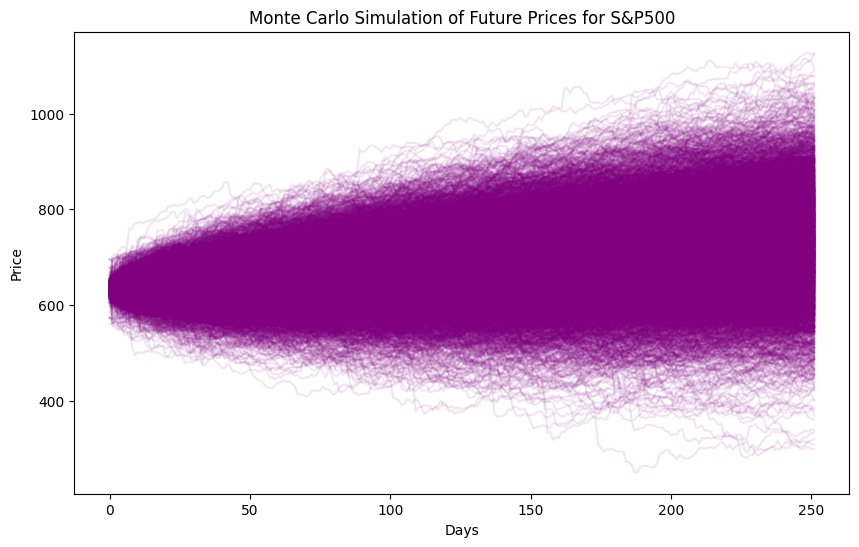

In [359]:
#Plot the results
plt.figure(figsize=(10,6))
plt.plot(simulations.T, color='purple', alpha = 0.1)
plt.title("Monte Carlo Simulation of Future Prices for S&P500")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

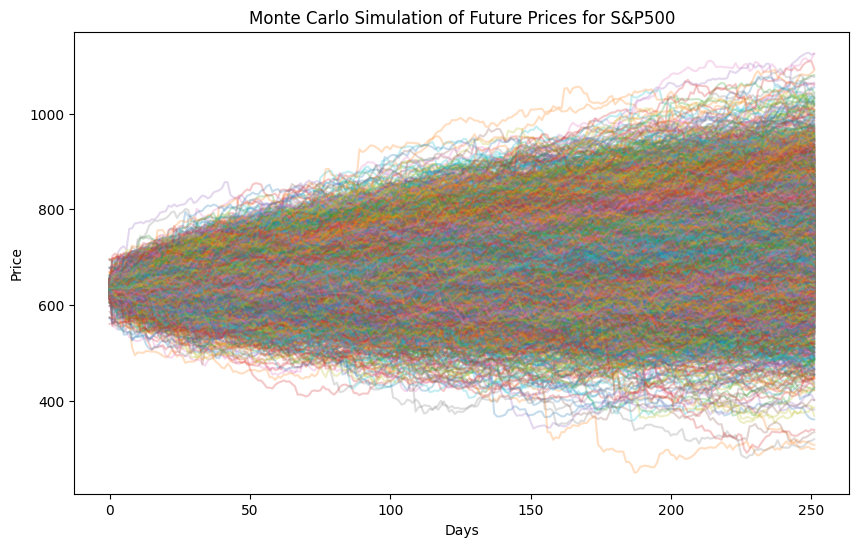

In [360]:
# Plot the results - Just made it more colourful with the help of the for loop and also increased the number of simulations by changing the value above
plt.figure(figsize=(10,6))
for i in range(num_simulations):
    plt.plot(simulations[i], alpha=0.25)
plt.title("Monte Carlo Simulation of Future Prices for S&P500")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

**Status:** The two graphs given above give an idea of the forecast of the S&P500 in 2026

## PART 2.1: 
**Import my portfolio, manage, clean and find stock allocations compared to portfolio size**

**Import and Clean Portfolio Data**

In [361]:
portfolio = pd.read_csv("Portfolio.csv", usecols=['Symbol', 'Exchange', 'Name', 'Market Value', 'Market Value Currency'])
portfolio = portfolio.dropna(subset=['Symbol'])
portfolio.head()

,Symbol,Exchange,Name,Market Value,Market Value Currency
0,AMD,TSX,Advanced Micro Devices CDR (CAD Hedged),280.850744,CAD
1,AMZN,TSX,Amazon.com CDR (CAD Hedged),106.012800,CAD
2,ANET,TSX,Arista Networks CDR (CAD Hedged),110.501561,CAD
3,CGL,TSX,BlackRock iShares Gold Bullion ETF CAD-Hedged,215.771859,CAD
4,COIN,NASDAQ,Coinbase Global Inc (Class A),88.401360,USD


**Standardize CDR stocks into stocks present in the NASDAQ for more accurate price movement**

In [362]:
def get_sim_ticker(row):
    symbol = str(row['Symbol']).strip()
    name = str(row['Name'])
    exchange = row['Exchange']
        
    if 'CDR' in name:
        return symbol 
    elif exchange == 'TSX':
        return f"{symbol}.TO" 
    
    return symbol

portfolio['Sim_Ticker'] = portfolio.apply(get_sim_ticker, axis=1)
portfolio.head()

,Symbol,Exchange,Name,Market Value,Market Value Currency,Sim_Ticker
0,AMD,TSX,Advanced Micro Devices CDR (CAD Hedged),280.850744,CAD,AMD
1,AMZN,TSX,Amazon.com CDR (CAD Hedged),106.012800,CAD,AMZN
2,ANET,TSX,Arista Networks CDR (CAD Hedged),110.501561,CAD,ANET
3,CGL,TSX,BlackRock iShares Gold Bullion ETF CAD-Hedged,215.771859,CAD,CGL.TO
4,COIN,NASDAQ,Coinbase Global Inc (Class A),88.401360,USD,COIN


**Live currency exchange (USD to CAD)**

In [363]:
# Converting USD holdings to CAD
usdcad_rate = yf.Ticker("USDCAD=X").history(period="1d")['Close'].iloc[-1]
def convert_to_cad(row):
    if row['Market Value Currency'] == 'USD':
        return row['Market Value'] * usdcad_rate
    return row['Market Value']

portfolio['Market_Value_CAD'] = portfolio.apply(convert_to_cad, axis=1)
portfolio.head()

,Symbol,Exchange,Name,Market Value,Market Value Currency,Sim_Ticker,Market_Value_CAD
0,AMD,TSX,Advanced Micro Devices CDR (CAD Hedged),280.850744,CAD,AMD,280.850744
1,AMZN,TSX,Amazon.com CDR (CAD Hedged),106.012800,CAD,AMZN,106.012800
2,ANET,TSX,Arista Networks CDR (CAD Hedged),110.501561,CAD,ANET,110.501561
3,CGL,TSX,BlackRock iShares Gold Bullion ETF CAD-Hedged,215.771859,CAD,CGL.TO,215.771859
4,COIN,NASDAQ,Coinbase Global Inc (Class A),88.401360,USD,COIN,120.899467


**Weight per stock**

In [364]:
total_value_cad = portfolio['Market_Value_CAD'].sum()
portfolio['Weight'] = portfolio['Market_Value_CAD']/total_value_cad
print(total_value_cad)
portfolio.head()

4345.335698925761


,Symbol,Exchange,Name,Market Value,Market Value Currency,Sim_Ticker,Market_Value_CAD,Weight
0,AMD,TSX,Advanced Micro Devices CDR (CAD Hedged),280.850744,CAD,AMD,280.850744,0.064633
1,AMZN,TSX,Amazon.com CDR (CAD Hedged),106.012800,CAD,AMZN,106.012800,0.024397
2,ANET,TSX,Arista Networks CDR (CAD Hedged),110.501561,CAD,ANET,110.501561,0.025430
3,CGL,TSX,BlackRock iShares Gold Bullion ETF CAD-Hedged,215.771859,CAD,CGL.TO,215.771859,0.049656
4,COIN,NASDAQ,Coinbase Global Inc (Class A),88.401360,USD,COIN,120.899467,0.027823


## PART 2.2: 
**Monte Carlo Simulation on my portfolio**

**Vector Creation**

In [365]:
weights = portfolio['Weight'].values
tickers = portfolio['Symbol'].values.tolist()

tickers[17] = "ORCL"     
tickers[25] = "VDY.TO"  
tickers[26] = "VEF.TO"
tickers[27]  = "VFV.TO"
tickers[3]  = "CGL.TO"

print(weights, tickers)

[0.06463269 0.02439692 0.02542993 0.04965597 0.02782281 0.02901402
 0.01703996 0.03784705 0.02681661 0.03385319 0.09038932 0.01939039
 0.01672988 0.03165199 0.02358064 0.02313714 0.03826033 0.02188829
 0.01392953 0.0209736  0.03492956 0.0301708  0.06933881 0.02998975
 0.0281351  0.05221504 0.03767589 0.08110479] ['AMD', 'AMZN', 'ANET', 'CGL.TO', 'COIN', 'FBTC', 'FETH', 'GOOG', 'IBM', 'LLY', 'META', 'MSFT', 'NFLX', 'NLR', 'NVDA', 'NVO', 'OKTA', 'ORCL', 'OSCR', 'PLTR', 'RDDT', 'SMCI', 'SOFI', 'UBER', 'UNH', 'VDY.TO', 'VEF.TO', 'VFV.TO']


**Import Data**

In [366]:
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  28 of 28 completed


**Weight Alignment**

In [367]:
weights_series = portfolio.groupby('Sim_Ticker')['Weight'].sum()
aligned_weights = weights_series.reindex(data.columns).fillna(0).values
aligned_weights

array([0.06463269, 0.02439692, 0.02542993, 0.04965597, 0.02782281,
       0.        , 0.        , 0.03784705, 0.02681661, 0.03385319,
       0.09038932, 0.01939039, 0.01672988, 0.03165199, 0.02358064,
       0.02313714, 0.03826033, 0.        , 0.01392953, 0.0209736 ,
       0.03492956, 0.0301708 , 0.06933881, 0.02998975, 0.0281351 ,
       0.05221504, 0.03767589, 0.08110479])

**Daily Portfolio Returns**

In [368]:
daily_returns = data.pct_change(fill_method=None).iloc[1:]
daily_returns = daily_returns.fillna(0)

port_returns = daily_returns.dot(aligned_weights)
port_returns.head()

Date
2006-01-04    0.001077
2006-01-05    0.003367
2006-01-06    0.003587
2006-01-09   -0.001059
2006-01-10    0.003413
dtype: float64

**Simulate Future Paths for Portfolio**

In [369]:
num_simulations = 5000
forecast_days = 252 
port_sims = np.zeros((num_simulations, forecast_days))

In [370]:
total_val = portfolio['Market_Value_CAD'].sum()
for i in range(num_simulations):
    rand = np.random.choice(port_returns, size=forecast_days, replace=True)
    port_sims[i] = total_val * (1 + rand).cumprod()

port_sims

array([[4341.19784745, 4419.24850099, 4420.63513409, ..., 5030.5348039 ,
        5023.88263203, 5002.88435644],
       [4433.18563729, 4536.4106267 , 4537.87256465, ..., 5396.38121488,
        5396.38121488, 5364.17521567],
       [4340.67773066, 4254.54942661, 4218.7664955 , ..., 4017.47900272,
        4001.57740314, 4042.23753179],
       ...,
       [4338.86710554, 4350.14427175, 4354.3277318 , ..., 5044.12139221,
        5072.53930169, 5062.03718694],
       [4223.00922707, 4200.92817716, 4212.33749835, ..., 4447.55778838,
        4439.23169018, 4461.20784887],
       [4298.97612196, 4269.0585815 , 4265.34333133, ..., 4130.23657739,
        4141.70016568, 4106.33926961]], shape=(5000, 252))

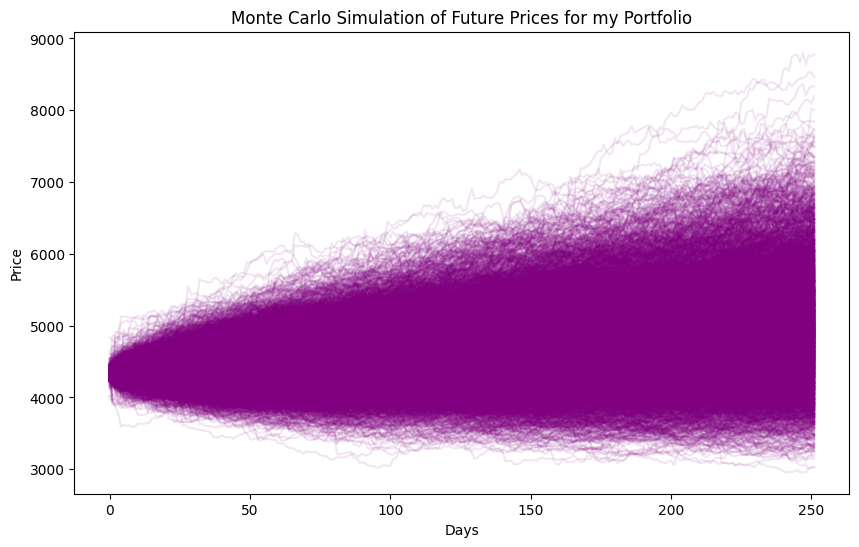

In [371]:
plt.figure(figsize=(10,6))
plt.plot(port_sims.T, color='purple', alpha = 0.1)
plt.title("Monte Carlo Simulation of Future Prices for my Portfolio")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

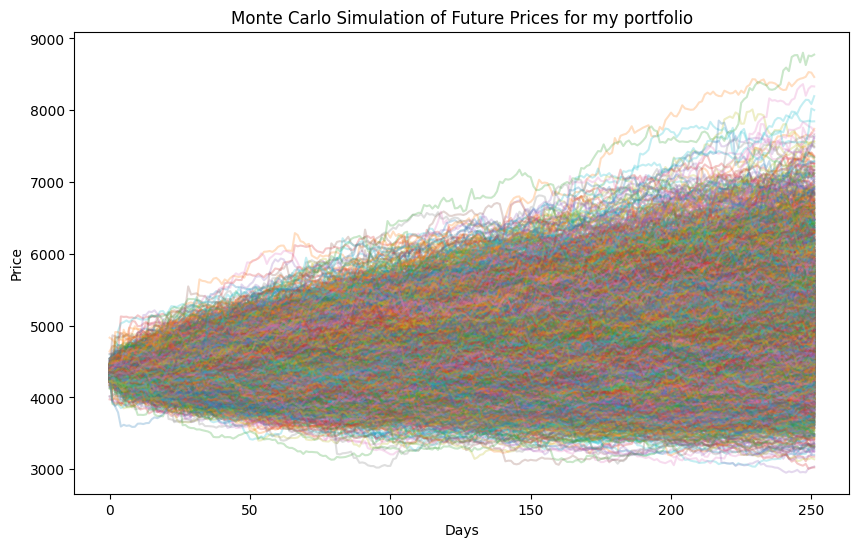

In [372]:
# Plot the results - Just made it more colourful with the help of the for loop and also increased the number of simulations by changing the value above
plt.figure(figsize=(10,6))
for i in range(num_simulations):
    plt.plot(port_sims[i], alpha=0.25)
plt.title("Monte Carlo Simulation of Future Prices for my portfolio")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

**Status:** Ran Monte Carlo Simulation on my Portfolio

## PART 3:
**Standardize both S&P500 and my Portfolio's graphs and compare side by side**

In [373]:
port_growth = port_sims / total_val
voo_growth = simulations / last_price

In [374]:
y_min = min(np.percentile(port_growth, 1), np.percentile(voo_growth, 1)) * 0.9
y_max = max(np.percentile(port_growth, 99), np.percentile(voo_growth, 99)) * 1.1

In [375]:
p5_port = np.percentile(port_growth, 5, axis=0)
p80_port = np.percentile(port_growth, 80, axis=0)

p5_voo = np.percentile(voo_growth, 5, axis=0)
p80_voo = np.percentile(voo_growth, 80, axis=0)

C:\Users\arnav\AppData\Local\Temp\ipykernel_7688\2920657977.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\arnav\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


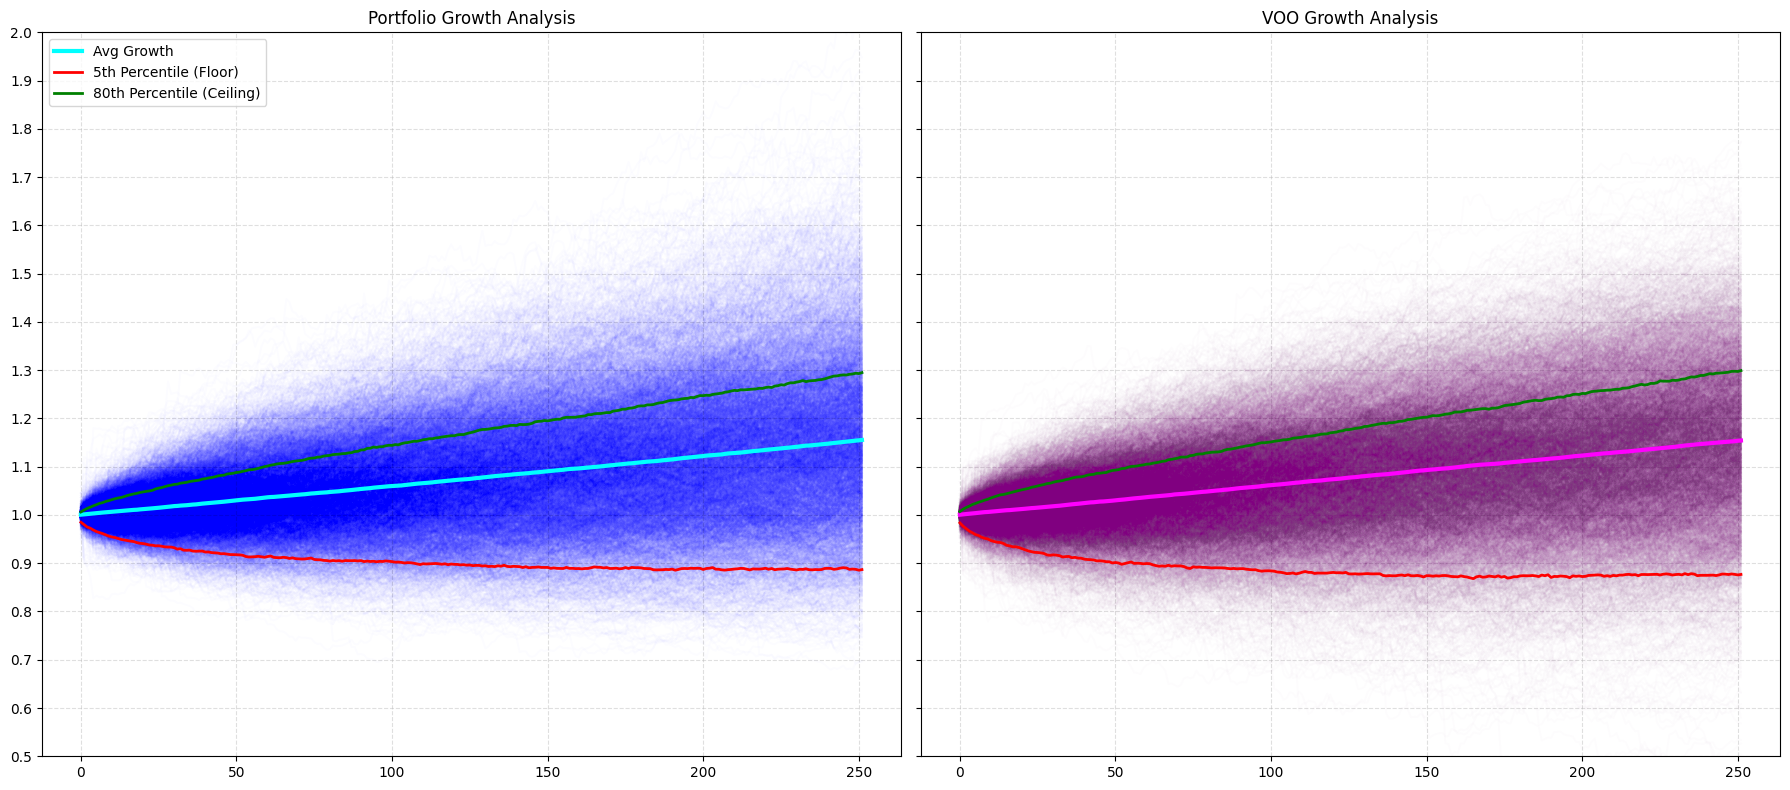

In [376]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

y_ticks = np.arange(0, 3.0, 0.1) 

ax1.plot(port_growth.T, color='blue', alpha=0.01)
ax1.plot(np.mean(port_growth, axis=0), color='cyan', lw=3, label='Avg Growth')
ax1.plot(p5_port, color='red', lw=2, label='5th Percentile (Floor)')
ax1.plot(p80_port, color='green', lw=2, label='80th Percentile (Ceiling)')
ax1.set_yticks(y_ticks)
ax1.set_title("Portfolio Growth Analysis")
ax1.grid(True, which='both', linestyle='--', alpha=0.4)
ax1.legend()

ax2.plot(voo_growth.T, color='purple', alpha=0.01)
ax2.plot(np.mean(voo_growth, axis=0), color='magenta', lw=3, label='Avg Growth')
ax2.plot(p5_voo, color='red', lw=2)
ax2.plot(p80_voo, color='green', lw=2)
ax2.set_yticks(y_ticks)
ax2.set_title("VOO Growth Analysis")
ax2.grid(True, which='both', linestyle='--', alpha=0.4)

plt.ylim(0.5, 2.0) 
plt.tight_layout()
plt.show()

## Performance Metrics

#### CAGR

In [377]:
portfolio_final_growth = port_growth[:, -1]
voo_final_growth = voo_growth[:, -1]

# Since horizon = 1 year, CAGR = total return = final value/initial value
portfolio_cagr = portfolio_final_growth - 1
voo_cagr = voo_final_growth - 1

portfolio_cagr_mean = np.mean(portfolio_cagr) * 100
portfolio_cagr_median = np.median(portfolio_cagr) * 100

voo_cagr_mean = np.mean(voo_cagr) * 100
voo_cagr_median = np.median(voo_cagr) * 100

print("Portfolio Expected 1-Year CAGR:", portfolio_cagr_mean,"%")
print("Portfolio Median 1-Year CAGR:", portfolio_cagr_median,"%")

print("VOO Expected 1-Year CAGR:", voo_cagr_mean,"%")
print("VOO Median 1-Year CAGR:", voo_cagr_median,"%")

Portfolio Expected 1-Year CAGR: 15.535899848471182 %
Portfolio Median 1-Year CAGR: 14.289811322918311 %
VOO Expected 1-Year CAGR: 15.424390595972604 %
VOO Median 1-Year CAGR: 15.47359262638337 %


#### Sharpe Ratio

In [378]:
#Import risk free rate
rf_rate = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100
rf_rate

np.float64(0.035429999828338624)

In [379]:
# Portfolio Sharpe Ratio 
port_mean_daily = np.mean(port_returns)
port_vol_daily = np.std(port_returns)

port_return_annual = port_mean_daily * forecast_days
port_vol_annual = port_vol_daily * np.sqrt(forecast_days) #risk adds up slower with time, sqrt makes sure that most of it cancels out 

portfolio_sharpe = (port_return_annual - rf_rate) / port_vol_annual
portfolio_sharpe

np.float64(0.7104597201891862)

In [380]:
# S&P500 Sharpe Ratio 

VOO_df = yf.download("VOO", start=start_date, end= end_date, auto_adjust=True)['Close']
voo_returns = VOO_df.pct_change(fill_method=None).dropna()

VOO_mean_daily = np.mean(voo_returns)
VOO_vol_daily = np.std(voo_returns)

VOO_return_annual = VOO_mean_daily * forecast_days
VOO_vol_annual = VOO_vol_daily * np.sqrt(forecast_days)

VOO_sharpe = (VOO_return_annual - rf_rate) / VOO_vol_annual
VOO_sharpe

[*********************100%***********************]  1 of 1 completed
C:\Users\arnav\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Ticker
VOO    0.686998
dtype: float64

#### Median Max Drawdown

In [381]:
def max_drawdown(path):
    running_max = np.maximum.accumulate(path)
    drawdown = (path - running_max) / running_max
    return drawdown.min()
    
portfolio_max_dd = np.array([max_drawdown(sim) for sim in port_sims])
portfolio_dd_median = np.median(portfolio_max_dd)

voo_max_dd = np.array([max_drawdown(sim) for sim in simulations])
voo_dd_median = np.median(voo_max_dd)

print(portfolio_dd_median * 100)
print(voo_dd_median * 100)

-11.090480486717725
-11.589046973075602


#### Tail Risk and Potential Upside

In [382]:
portfolio_final_growth = port_growth[:, -1]
voo_final_growth = voo_growth[:, -1]

portfolio_returns = portfolio_final_growth - 1
voo_returns = voo_final_growth - 1

In [383]:
p5_port = np.percentile(portfolio_returns, 5, axis=0)
p80_port = np.percentile(portfolio_returns, 80, axis=0)

p5_voo = np.percentile(voo_returns, 5, axis=0)
p80_voo = np.percentile(voo_returns, 80, axis=0)

print(p5_port* 100, p80_port* 100)
print(p5_voo * 100, p80_voo * 100)

-11.323386453576147 29.491708055465534
-12.32328078699526 29.908427008689475


#### Outperformance Probability

In [384]:
portfolio_final = port_growth[:, -1]
voo_final = voo_growth[:, -1]

outperform_list = portfolio_final > voo_final

prob_outperform = np.mean(outperform_list)
prob_outperform

np.float64(0.4912)